In [1]:
import pandas as pd
import numpy as np
import gc

In [2]:
import mlflow
from mlflow.tracking import MlflowClient
import time 

In [3]:
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.binary import BinaryEncoder

from sklearn.metrics import confusion_matrix, matthews_corrcoef, precision_score, recall_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

In [4]:
RANDOM_SEED = 22

In [5]:
mlflow.autolog()

2022/07/26 02:33:05 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2022/07/26 02:33:05 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/07/26 02:33:06 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [6]:
mlflow.get_tracking_uri()

'file:///home/hdd_n/Desktop/hnnaharendt/feedback-kaggle/mlruns'

In [5]:
train_path = "train.csv"
test_path =  "test.csv"
sample_path = "sample_submission.csv"

In [6]:
data = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample = pd.read_csv(sample_path)

In [7]:
data.columns

Index(['discourse_id', 'essay_id', 'discourse_text', 'discourse_type',
       'discourse_effectiveness'],
      dtype='object')

In [8]:
data['essay_text'] = data['essay_id'].apply(lambda x: open(f"train/{x}.txt").read())

In [9]:
target_labels_mapping = {"Ineffective": 0, "Adequate":1, "Effective":2}
data.discourse_effectiveness = data.discourse_effectiveness.map(target_labels_mapping)

In [10]:
data.discourse_effectiveness.value_counts()

1    20977
2     9326
0     6462
Name: discourse_effectiveness, dtype: int64

In [11]:
data.drop(['discourse_id', 'essay_id'], axis = 1, inplace = True)

In [12]:
data

,discourse_text,discourse_type,discourse_effectiveness,essay_text
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,1,"Hi, i'm Isaac, i'm going to be writing about h..."
1,"On my perspective, I think that the face is a ...",Position,1,"Hi, i'm Isaac, i'm going to be writing about h..."
2,I think that the face is a natural landform be...,Claim,1,"Hi, i'm Isaac, i'm going to be writing about h..."
3,"If life was on Mars, we would know by now. The...",Evidence,1,"Hi, i'm Isaac, i'm going to be writing about h..."
4,People thought that the face was formed by ali...,Counterclaim,1,"Hi, i'm Isaac, i'm going to be writing about h..."
...,...,...,...,...
36760,For many people they don't like only asking on...,Claim,1,Some people may ask multiple people for advice...
36761,also people have different views and opinions ...,Claim,1,Some people may ask multiple people for advice...
36762,Advice is something that can impact a persons ...,Position,1,Some people may ask multiple people for advice...
36763,someone can use everything that many people sa...,Evidence,0,Some people may ask multiple people for advice...


In [13]:
train_data, test_data = train_test_split(data, test_size = .20, random_state=RANDOM_SEED, stratify=data.discourse_effectiveness)

In [14]:
print(f"Train set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")

Train set shape: (29412, 4)
Test set shape: (7353, 4)


In [53]:
num_folds = 3

In [54]:
skf = StratifiedKFold(n_splits=num_folds, random_state=RANDOM_SEED, shuffle=True)

In [55]:
train_data

,discourse_text,discourse_type,discourse_effectiveness,essay_text
8629,"Instead of laying on the couch, eating, sleepi...",Evidence,1,If the Summer is plagued with more work we sho...
10274,like some simplified electronics made of silic...,Evidence,1,No one has ever landed on venus so the author ...
4293,"Second, now to the conspiracy theorists, they ...",Counterclaim,1,"First of all, NASA only gets their information..."
2443,Third example has pathos catching peoples feel...,Claim,0,I think that the author describes how technolg...
16589,it would also in the world of to day make him ...,Claim,0,"Dear Principle,\n\nI personally do not think s..."
...,...,...,...,...
3015,it's their summer.,Claim,1,"When assigned a project during summer break, d..."
26587,I think people should be able to choose who t...,Evidence,0,"Dear, State Sentor\n\nI think the electoral co..."
19477,But you see there is up side to using the Elec...,Counterclaim,1,"Dear Floridas state senator, I am righting thi..."
30083,but we should at least get a vote on like new ...,Rebuttal,0,"Dear senator,\n\nGetting ride of the Electoral..."


In [56]:
train_data

,discourse_text,discourse_type,discourse_effectiveness,essay_text
8629,"Instead of laying on the couch, eating, sleepi...",Evidence,1,If the Summer is plagued with more work we sho...
10274,like some simplified electronics made of silic...,Evidence,1,No one has ever landed on venus so the author ...
4293,"Second, now to the conspiracy theorists, they ...",Counterclaim,1,"First of all, NASA only gets their information..."
2443,Third example has pathos catching peoples feel...,Claim,0,I think that the author describes how technolg...
16589,it would also in the world of to day make him ...,Claim,0,"Dear Principle,\n\nI personally do not think s..."
...,...,...,...,...
3015,it's their summer.,Claim,1,"When assigned a project during summer break, d..."
26587,I think people should be able to choose who t...,Evidence,0,"Dear, State Sentor\n\nI think the electoral co..."
19477,But you see there is up side to using the Elec...,Counterclaim,1,"Dear Floridas state senator, I am righting thi..."
30083,but we should at least get a vote on like new ...,Rebuttal,0,"Dear senator,\n\nGetting ride of the Electoral..."


In [57]:
train_data.discourse_effectiveness.value_counts()

1    16781
2     7461
0     5170
Name: discourse_effectiveness, dtype: int64

In [58]:
X, Y = train_data.drop('discourse_effectiveness', axis=1, inplace = False), train_data.discourse_effectiveness

In [59]:
train_indices, test_indices = list(skf.split(X, Y))[0]

In [60]:
X.iloc[train_indices]

,discourse_text,discourse_type,essay_text
8629,"Instead of laying on the couch, eating, sleepi...",Evidence,If the Summer is plagued with more work we sho...
10274,like some simplified electronics made of silic...,Evidence,No one has ever landed on venus so the author ...
4293,"Second, now to the conspiracy theorists, they ...",Counterclaim,"First of all, NASA only gets their information..."
16589,it would also in the world of to day make him ...,Claim,"Dear Principle,\n\nI personally do not think s..."
8029,possible solution to the hostile condition on ...,Evidence,The author suggest that studying venus is a wo...
...,...,...,...
12974,and they need time to do their homework.,Claim,Can you believe that schools are now making st...
3015,it's their summer.,Claim,"When assigned a project during summer break, d..."
26587,I think people should be able to choose who t...,Evidence,"Dear, State Sentor\n\nI think the electoral co..."
19477,But you see there is up side to using the Elec...,Counterclaim,"Dear Floridas state senator, I am righting thi..."


In [61]:
Y.iloc[train_indices]

8629     1
10274    1
4293     1
16589    0
8029     1
        ..
12974    1
3015     1
26587    0
19477    1
7207     0
Name: discourse_effectiveness, Length: 19608, dtype: int64

In [62]:
from cuml.linear_model.logistic_regression import LogisticRegression

In [63]:
fold_counter = 1
predictions = []

losses = []

for train_idxs, test_idxs in skf.split(X = X, y = Y):
    
    print()
    print(f"Fold #{fold_counter}")
    # print(X.shape, Y.shape)

    X_train, Y_train = X.iloc[train_idxs], Y.iloc[train_idxs]
    X_test, Y_test = X.iloc[test_idxs], Y.iloc[test_idxs]

    vectorizer = TfidfVectorizer()
    vectorizer.fit(X_train.essay_text.drop_duplicates())

    vectorized_discourse_text_train = vectorizer.transform(X_train.discourse_text)
    vectorized_discourse_text_test = vectorizer.transform(X_test.discourse_text)

    ohe = OneHotEncoder()
    ohe_discourse_type_train = ohe.fit_transform(X_train.discourse_type.values.reshape(-1, 1))
    ohe_discourse_type_test = ohe.transform(X_test.discourse_type.values.reshape(-1, 1))

    X_train = sparse.hstack((vectorized_discourse_text_train, ohe_discourse_type_train))
    X_test = sparse.hstack((vectorized_discourse_text_test, ohe_discourse_type_test))
    
    # print(f"Vectorized data shape:")
    # print(f"\t{X_train.shape}")
    # print(f"\t{Y_train.shape}")
    # print(f"\t{X_test.shape}")
    # print(f"\t{Y_test.shape}")


    model = LogisticRegression()
    model.fit(X_train, Y_train)
    y_pred = model.predict_proba(X_test)

    loss = log_loss(y_true = Y_test, y_pred = y_pred)
    losses.append(loss)
    print(f"\tLog loss: {loss:.4}")

    print(80*'.')
    

    fold_counter += 1

print(80*'=')
print(f"Mean loss: {np.mean(losses):.4}")


Fold #1
	Log loss: 0.7851
................................................................................

Fold #2
	Log loss: 0.7943
................................................................................

Fold #3
	Log loss: 0.7769
................................................................................
Mean loss: 0.7855


In [64]:
fold_counter = 1
predictions = []

losses = []

for train_idxs, test_idxs in skf.split(X = X, y = Y):
    
    print()
    print(f"Fold #{fold_counter}")
    # print(X.shape, Y.shape)

    X_train, Y_train = X.iloc[train_idxs], Y.iloc[train_idxs]
    X_test, Y_test = X.iloc[test_idxs], Y.iloc[test_idxs]

    vectorizer = TfidfVectorizer()
    vectorizer.fit(X_train.essay_text.drop_duplicates())

    vectorized_discourse_text_train = vectorizer.transform(X_train.discourse_text)
    vectorized_discourse_text_test = vectorizer.transform(X_test.discourse_text)

    ohe = OneHotEncoder()
    ohe_discourse_type_train = ohe.fit_transform(X_train.discourse_type.values.reshape(-1, 1))
    ohe_discourse_type_test = ohe.transform(X_test.discourse_type.values.reshape(-1, 1))

    X_train = sparse.hstack((vectorized_discourse_text_train, ohe_discourse_type_train))
    X_test = sparse.hstack((vectorized_discourse_text_test, ohe_discourse_type_test))
    
    # print(f"Vectorized data shape:")
    # print(f"\t{X_train.shape}")
    # print(f"\t{Y_train.shape}")
    # print(f"\t{X_test.shape}")
    # print(f"\t{Y_test.shape}")


    model = LogisticRegression()
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    loss = log_loss(y_true = Y_test, y_pred = y_pred, labels=[0,1,2])
    losses.append(loss)
    print(f"\tLog loss: {loss:.4}")

    print(80*'.')
    

    fold_counter += 1

print(80*'=')
print(f"Mean loss: {np.mean(losses):.4}")


Fold #1


ValueError: The number of classes in labels is different from that in y_pred. Classes found in labels: [0 1 2]

In [68]:
y_pred[:,:,:]

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [66]:
Y_test

2443     0
28568    0
31014    1
8081     0
3896     0
        ..
32679    1
20658    0
16917    1
11908    1
30083    0
Name: discourse_effectiveness, Length: 9804, dtype: int64

In [39]:
y_pred

array([[0.46227647, 0.41620552, 0.12151801],
       [0.26090171, 0.53043784, 0.20866045],
       [0.34768194, 0.56750608, 0.08481198],
       ...,
       [0.14515932, 0.68320297, 0.17163771],
       [0.17517479, 0.64892156, 0.17590365],
       [0.31420527, 0.61531654, 0.0704782 ]])

In [69]:
from cuml.svm import SVC

Fold #1


2022/07/26 03:10:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ee288593db5b4c4da142be1fa8488757', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/home/hdd_n/mambaforge/envs/rapids-22.04/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/hdd_n/mambaforge/envs/rapids-22.04/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
2022/07/26 03:13:05 WARNING mlflow.sklearn.

ValueError: The number of classes in labels is different from that in y_pred. Classes found in labels: [0 1 2]

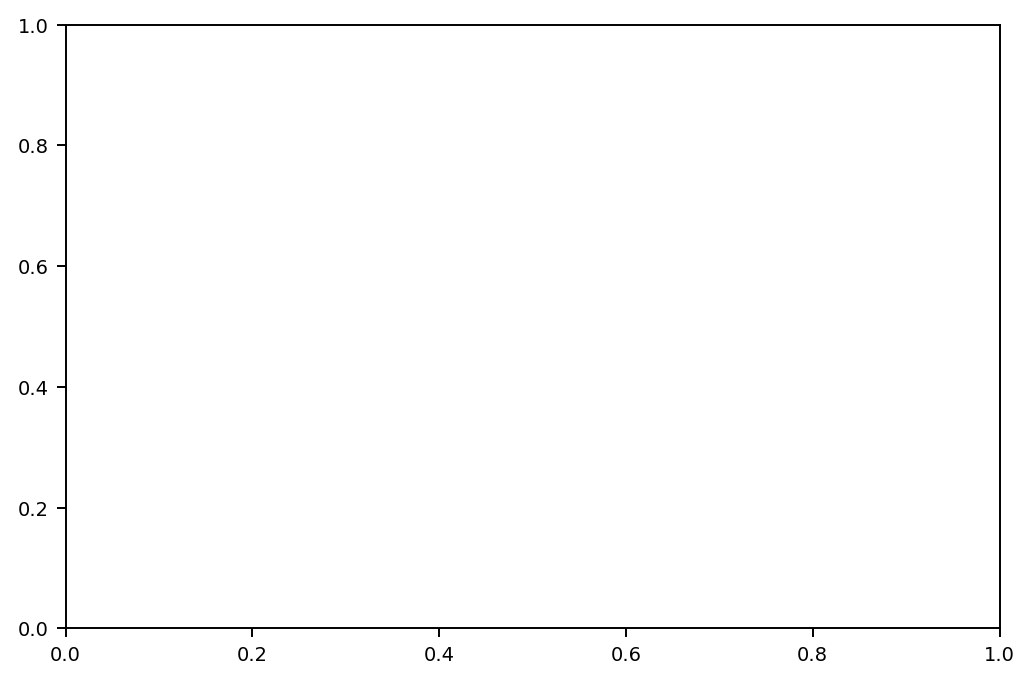

In [45]:
fold_counter = 1
predictions = []
y_pred_final_lr = np.zeros((X_test.shape[0], 3))


for train_idxs, test_idxs in skf.split(X = X, y = Y):
    
    print(f"Fold #{fold_counter}")
    # print(X.shape, Y.shape)

    X_train, Y_train = X.iloc[train_idxs], Y.iloc[train_idxs]
    X_test, Y_test = X.iloc[test_idxs], Y.iloc[test_idxs]


    vectorizer = TfidfVectorizer()
    vectorizer.fit(X_train.essay_text.drop_duplicates())

    vectorized_discourse_text_train = vectorizer.transform(X_train.discourse_text)
    vectorized_discourse_text_test = vectorizer.transform(X_test.discourse_text)

    ohe = OneHotEncoder()
    ohe_discourse_type_train = ohe.fit_transform(X_train.discourse_type.values.reshape(-1, 1))
    ohe_discourse_type_test = ohe.transform(X_test.discourse_type.values.reshape(-1, 1))

    X_train = sparse.hstack((vectorized_discourse_text_train, ohe_discourse_type_train))
    X_test = sparse.hstack((vectorized_discourse_text_test, ohe_discourse_type_test))
    
    # print(f"Vectorized data shape:")
    # print(f"\t{X_train.shape}")
    # print(f"\t{Y_train.shape}")
    # print(f"\t{X_test.shape}")
    # print(f"\t{Y_test.shape}")


    model = SVC()
    model.fit(X_train.todense(), Y_train)
    y_pred = model.predict(X_test.todense())

    loss = log_loss(y_true = Y_test, y_pred = y_pred, labels=[0,1,2])

    print(f"\tLog loss: {loss}")

    print(80*'.')
    print()

    fold_counter += 1


Hopefully this will do, last time one fold took apprx. one hour. let's see. v

In [86]:
fold_counter = 1
predictions = []
y_pred_final_lr = np.zeros((X_test.shape[0], 3))



X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.20, random_state=RANDOM_SEED)


vectorizer = TfidfVectorizer()
vectorizer.fit(X_train.essay_text.drop_duplicates())

vectorized_discourse_text_train = vectorizer.transform(X_train.discourse_text)
vectorized_discourse_text_test = vectorizer.transform(X_test.discourse_text)

ohe = OneHotEncoder()
ohe_discourse_type_train = ohe.fit_transform(X_train.discourse_type.values.reshape(-1, 1))
ohe_discourse_type_test = ohe.transform(X_test.discourse_type.values.reshape(-1, 1))

X_train = sparse.hstack((vectorized_discourse_text_train, ohe_discourse_type_train))
X_test = sparse.hstack((vectorized_discourse_text_test, ohe_discourse_type_test))

# print(f"Vectorized data shape:")
# print(f"\t{X_train.shape}")
# print(f"\t{Y_train.shape}")
# print(f"\t{X_test.shape}")
# print(f"\t{Y_test.shape}")


model = SVC()
model.fit(X_train.todense(), Y_train)
y_pred = model.predict(X_test.todense())

n_values = np.max(np.unique(y_pred)) + 1
y_pred = np.eye(n_values)[y_pred]

loss = log_loss(y_true = Y_test, y_pred = y_pred)



print(f"\tLog loss: {loss}")

print(80*'.')
print()

fold_counter += 1

/home/hdd_n/mambaforge/envs/rapids-22.04/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/hdd_n/mambaforge/envs/rapids-22.04/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


	Log loss: 12.100020083275696
................................................................................



In [84]:
n_values = np.max(np.unique(y_pred)) + 1
cc = np.eye(n_values)[y_pred]

In [85]:
np.unique(cc)

array([0., 1.])

In [80]:
np.unique(Y_test)

array([0, 1, 2])

In [82]:

ohe_pred = OneHotEncoder()
ohe_pred.fit_transform(y_pred)

ValueError: Expected 2D array, got 1D array instead:
array=[1 1 1 ... 1 1 1].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [73]:

gc.collect()

1865

In [72]:
del model,
del X_test, Y_test
del X_train, Y_train


NameError: name 'model' is not defined